In [1]:
import os
import errno
import numpy as np 
import deepcell
from deepcell_toolbox.processing import phase_preprocess

In [2]:
# create folder for this set of experiments
experiment_folder = "20200619_production_updates"
MODEL_DIR = os.path.join("/data/models", experiment_folder)
NPZ_DIR = "/data/npz_data/"
LOG_DIR = '/data/logs'

In [3]:
from deepcell.utils.data_utils import get_data
from skimage.segmentation import relabel_sequential

npz_name = "20200908_multiplex"

test_dict = np.load(NPZ_DIR + npz_name + "_test_256x256.npz")
X_test, y_test = test_dict['X'], test_dict['y']

In [4]:
k=128
X_test = phase_preprocess(X_test, k)

In [5]:
X_test.shape

(2029, 256, 256, 2)

In [5]:
from deepcell.model_zoo.panopticnet import PanopticNet
model = PanopticNet(
    backbone='resnet50',
    input_shape=(256, 256, 2),
    norm_method=None,
    num_semantic_heads=4,
    num_semantic_classes=[1, 3, 1, 3], # inner distance, outer distance, fgbg, pixelwise
    location=True,  # should always be true
    include_top=True)

W0911 20:47:52.389632 140182140327744 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [26]:
model_name = npz_name + '_deep_watershed.h5'

In [6]:
model_name = '20200908_multiplex__nuclear__deep_watershed.h5'

In [7]:
model_name = '20200908_multiplex_deep_watershed_2_head.h5'

In [7]:
model.load_weights(os.path.join(MODEL_DIR, model_name))

In [8]:
from deepcell_toolbox.utils import tile_image, untile_image
from deepcell.applications import MultiplexSegmentation
app = MultiplexSegmentation(use_pretrained_weights=False)

In [ ]:
inner_distance, outer_distance, fgbg, pixelwise = model.predict(X_test)

In [9]:
inner_cell, pixel_cell, inner_nuc, pixel_nuc = model.predict(X_test)

In [10]:
inner_distance, pixelwise = model.predict(X_test)

In [12]:
from deepcell_toolbox.deep_watershed import deep_watershed_mibi
labeled_images = deep_watershed_mibi({'inner-distance': inner_distance,
                                     'pixelwise-interior': pixelwise[:, :, :, 1:2]}, 
                                     maxima_threshold=0.02, maxima_model_smooth=0,
                                     interior_model_smooth=2,
                                    interior_threshold=0.3,
                                    radius=5,
                                    small_objects_threshold=10,
                                     fill_holes_threshold=10)

In [16]:
from deepcell_toolbox.deep_watershed import deep_watershed_mibi
labeled_images = deep_watershed_mibi({'inner-distance': inner_nuc,
                                     'pixelwise-interior': pixel_nuc[:, :, :, 1:2]}, 
                                     maxima_threshold=0.02, maxima_model_smooth=0,
                                     interior_model_smooth=2,
                                    interior_threshold=0.4,
                                    radius=5,
                                    small_objects_threshold=10,
                                     fill_holes_threshold=10)

In [22]:
# or use an application
app.model.load_weights(MODEL_DIR + "/20200819_multiplex_normalized_512x512_compartment_deep_watershed.h5")

In [23]:
labeled_images = app.predict(image=X_test, image_mpp=0.5, compartment='nuclear',  
                     postprocess_kwargs_nuclear={'interior_threshold': 0.5, 'interior_model_smooth': 0,
                                                'maxima_model_smooth': 0, 'pixel_expansion': 3,
                                                'maxima_threshold':0.05, 'maxima_model_smooth': 0,
                                  'radius':5,
                                  'small_objects_threshold':10,
                                  'fill_holes_threshold':10})

In [11]:
from skimage.exposure import rescale_intensity
from skimage.segmentation import find_boundaries
import copy
def make_color_overlay(input_data):
    """Create a color overlay from 2 channel image data
    
    Args:
        input_data: stack of input images
    
    Returns:
        numpy.array: color-adjusted stack of overlays in RGB mode
    """
    RGB_data = np.zeros(input_data.shape[:3] + (3, ), dtype='float32')
    
    # rescale channels to aid plotting
    for img in range(input_data.shape[0]):
        for channel in range(input_data.shape[-1]):
            # get histogram for non-zero pixels
            percentiles = np.percentile(input_data[img, :, :, channel][input_data[img, :, :, channel] > 0],
                                            [5, 95])
            rescaled_intensity = rescale_intensity(input_data[img, :, :, channel],
                                                       in_range=(percentiles[0], percentiles[1]),
                                                       out_range='float32')
            RGB_data[img, :, :, channel + 1] = rescaled_intensity
        
    # create a blank array for red channel
    return RGB_data

def make_outline_overlay(RGB_data, predictions):
    boundaries = np.zeros_like(predictions)
    overlay_data = copy.copy(RGB_data)
    
    for img in range(predictions.shape[0]):
        boundary = find_boundaries(predictions[img], connectivity=1, mode='inner')
        boundaries[img, boundary > 0] = 1

    overlay_data[boundaries > 0, :] = 1
    
    return overlay_data

In [12]:
RGB_data = make_color_overlay(X_test[:, :, :, :])
true_overlay = make_outline_overlay(RGB_data, y_test[:, :, :, 0])

In [17]:
predicted_overlay = make_outline_overlay(RGB_data, labeled_images[..., 0])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  This is separate from the ipykernel package so we can avoid doing imports until


NameError: name 'inner_distance' is not defined

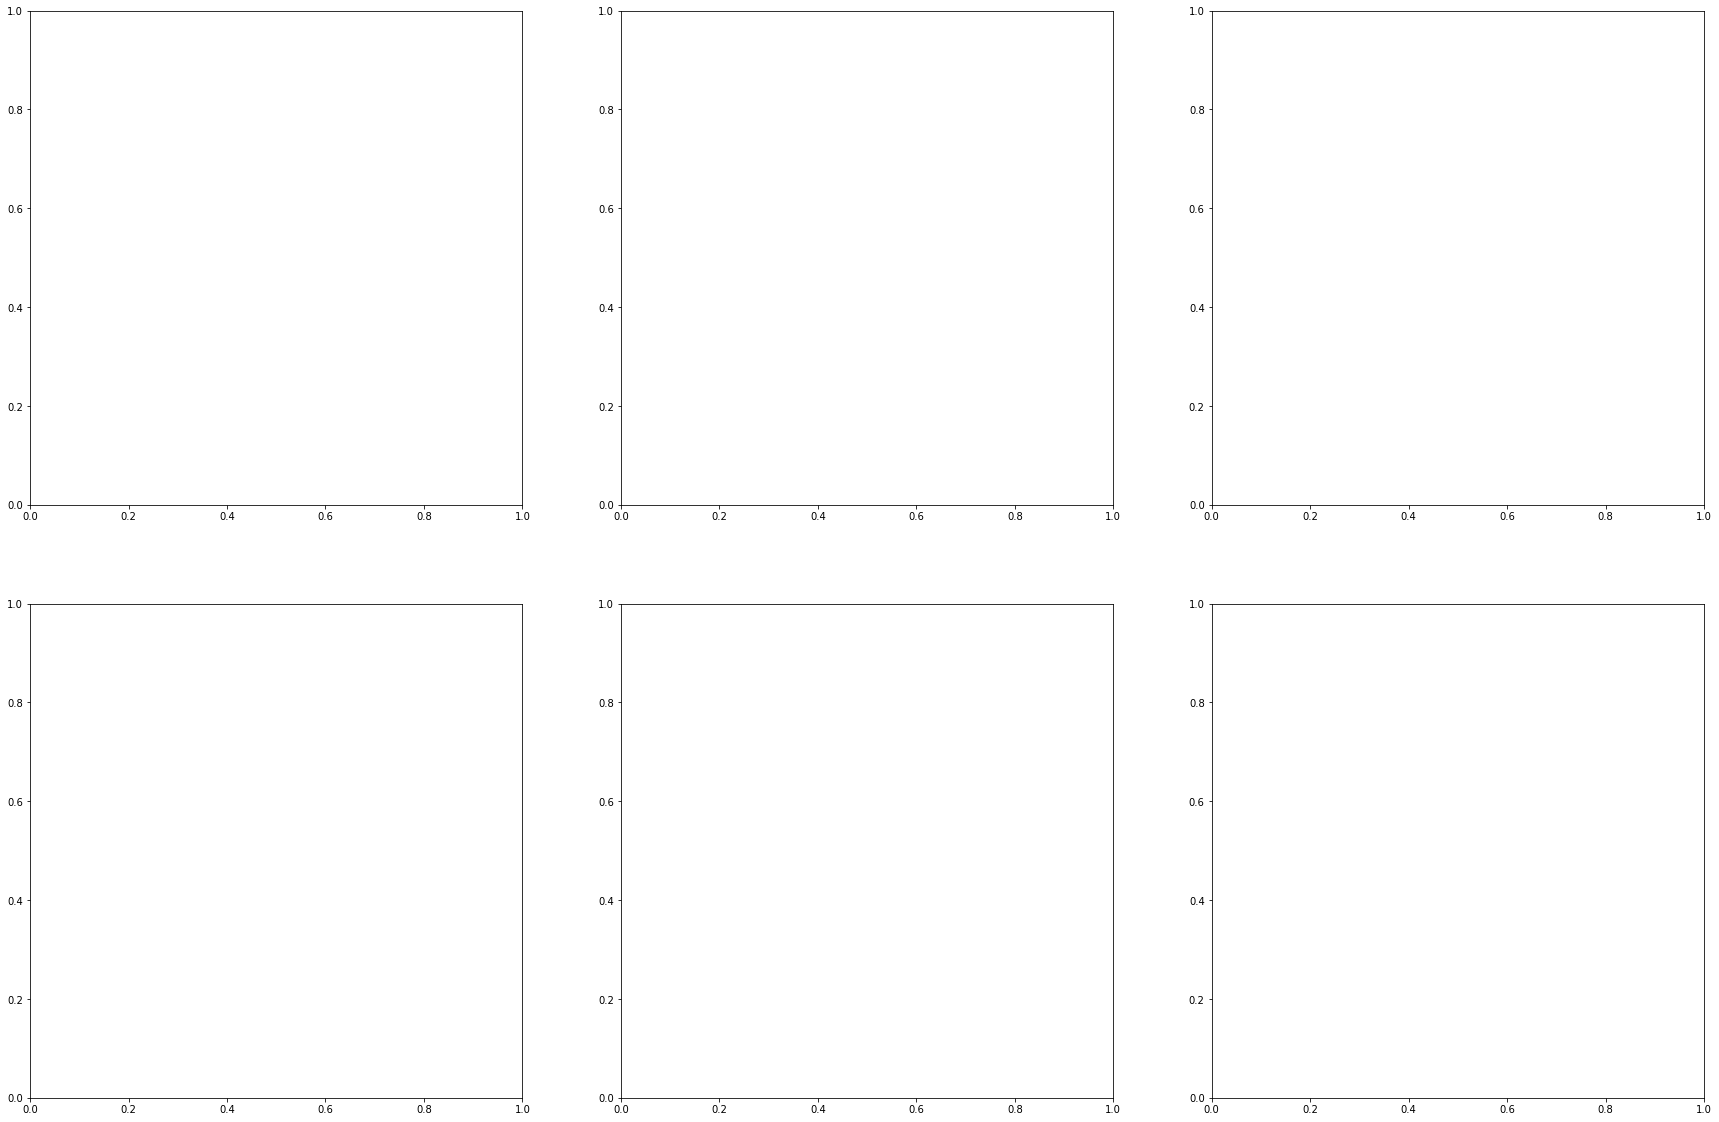

In [18]:
import matplotlib.pyplot as plt
cmap = plt.get_cmap('viridis')
cmap.set_bad('black')
index = 400
fig, axes = plt.subplots(2,3,figsize=(30,20))

axes = axes.flatten()
#axes[0].imshow(outer_distance[index[0],..., 0])
axes[1].imshow(inner_distance[index,...,0], cmap='jet')
axes[2].imshow(pixelwise[index,...,1], cmap='jet')
axes[3].imshow(predicted_overlay[index, ...], cmap=cmap)
axes[4].imshow(true_overlay[index, ...], cmap=cmap)

axes[0].set_title('Outer Distance', fontsize=24)
axes[1].set_title('Inner distance', fontsize=24)
axes[2].set_title('Pixelwise Border', fontsize=24)
axes[3].set_title('Predicted Overlay', fontsize=24)
axes[4].set_title('True Overlay', fontsize=24)
# axes[5].set_title('Ground Truth Mask', fontsize=24)

for ax in axes.flatten():
    ax.set_axis_off()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  This is separate from the ipykernel package so we can avoid doing imports until


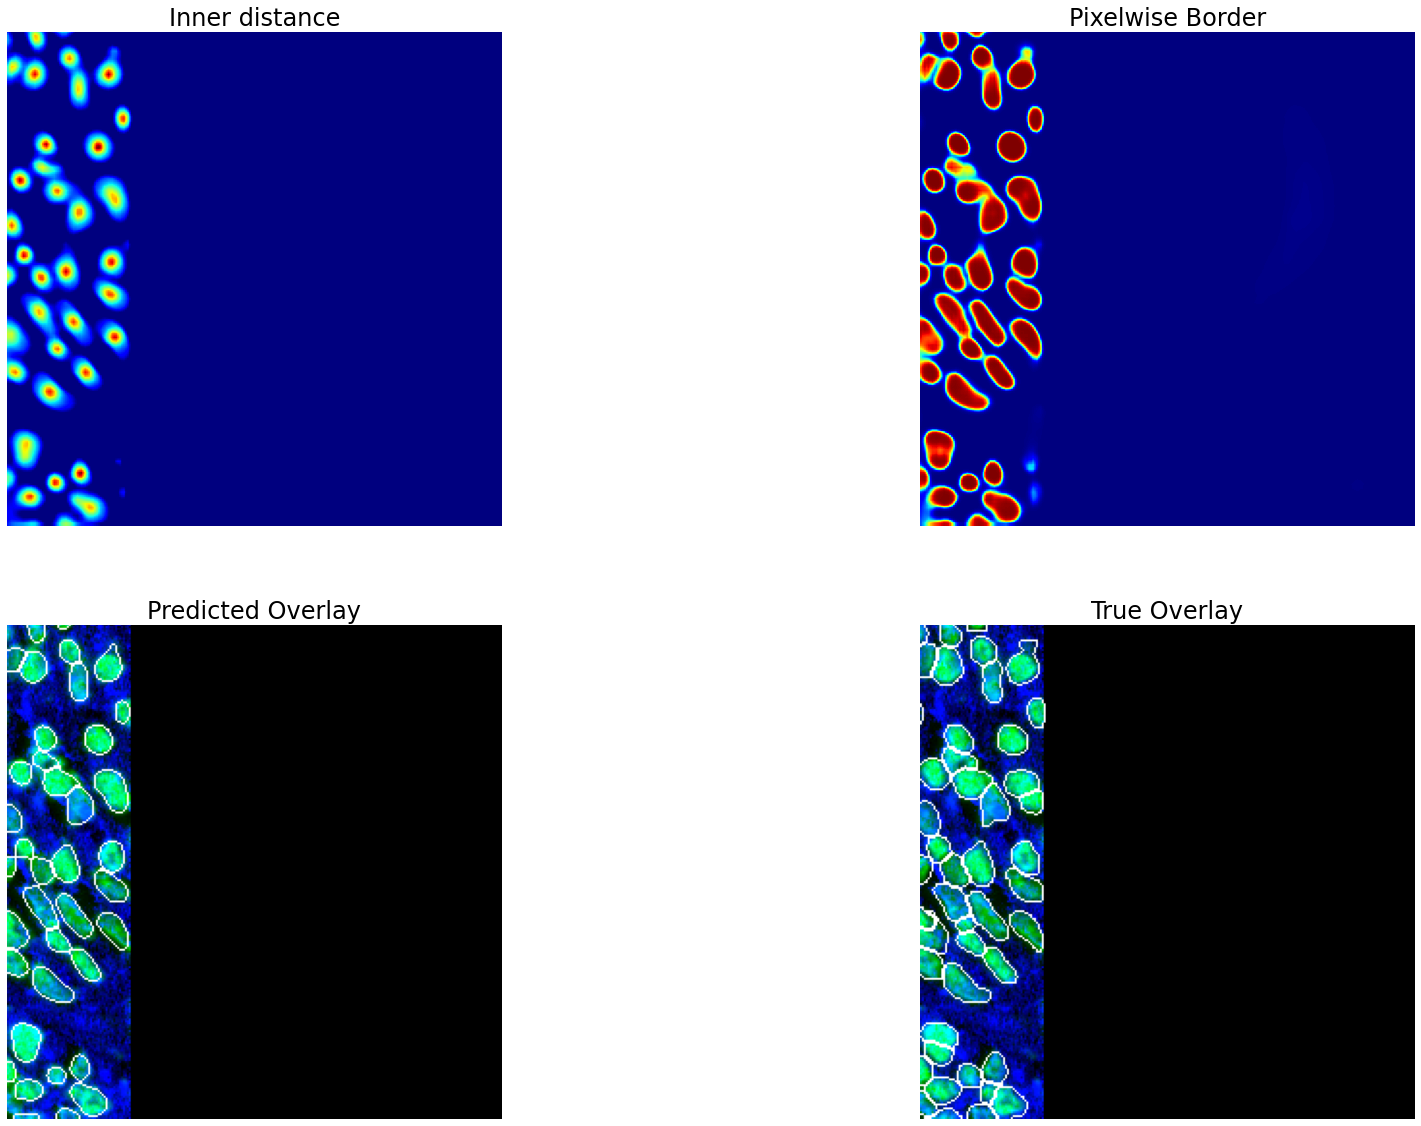

In [25]:
import matplotlib.pyplot as plt
cmap = plt.get_cmap('viridis')
cmap.set_bad('black')
index = 750
fig, axes = plt.subplots(2,2,figsize=(30,20))

axes = axes.flatten()
axes[0].imshow(inner_nuc[index,...,0], cmap='jet')
axes[1].imshow(pixel_nuc[index,...,1], cmap='jet')
axes[2].imshow(predicted_overlay[index, ...], cmap=cmap)
axes[3].imshow(true_overlay[index, ...], cmap=cmap)

axes[0].set_title('Inner distance', fontsize=24)
axes[1].set_title('Pixelwise Border', fontsize=24)
axes[2].set_title('Predicted Overlay', fontsize=24)
axes[3].set_title('True Overlay', fontsize=24)

for ax in axes.flatten():
    ax.set_axis_off()

In [21]:
db = DatasetBenchmarker(y_true=y_test, 
                       y_pred=labeled_images,
                       tissue_list=test_dict['tissue_list'],
                       platform_list=test_dict['platform_list'],
                       model_name='default_model')
tissue_stats, platform_stats = db.benchmark()

calculating image 0
calculating image 1
calculating image 2
calculating image 3
calculating image 4
calculating image 5
calculating image 6
calculating image 7
calculating image 8
calculating image 9
calculating image 10
calculating image 11
calculating image 12
calculating image 13
calculating image 14
calculating image 15
calculating image 16
calculating image 17
calculating image 18
calculating image 19
calculating image 20
calculating image 21
calculating image 22
calculating image 23
calculating image 24
calculating image 25
calculating image 26
calculating image 27
calculating image 28
calculating image 29
calculating image 30
calculating image 31
calculating image 32
calculating image 33
calculating image 34
calculating image 35
calculating image 36
calculating image 37
calculating image 38
calculating image 39
calculating image 40
calculating image 41
calculating image 42
calculating image 43
calculating image 44
calculating image 45
calculating image 46
calculating image 47
ca

calculating image 378
calculating image 379
calculating image 380
calculating image 381
calculating image 382
calculating image 383
calculating image 384
calculating image 385
calculating image 386
calculating image 387
calculating image 388
calculating image 389
calculating image 390
calculating image 391
calculating image 392
calculating image 393
calculating image 394
calculating image 395
calculating image 396
calculating image 397
calculating image 398
calculating image 399
calculating image 400
calculating image 401
calculating image 402
calculating image 403
calculating image 404
calculating image 405
calculating image 406
calculating image 407
calculating image 408
calculating image 409
calculating image 410
calculating image 411
calculating image 412
calculating image 413
calculating image 414
calculating image 415
calculating image 416
calculating image 417
calculating image 418
calculating image 419
calculating image 420
calculating image 421
calculating image 422
calculatin

calculating image 752
calculating image 753
calculating image 754
calculating image 755
calculating image 756
calculating image 757
calculating image 758
calculating image 759
calculating image 760
calculating image 761
calculating image 762
calculating image 763
calculating image 764
calculating image 765
calculating image 766
calculating image 767
calculating image 768
calculating image 769
calculating image 770
calculating image 771
calculating image 772
calculating image 773
calculating image 774
calculating image 775
calculating image 776
calculating image 777
calculating image 778
calculating image 779
calculating image 780
calculating image 781
calculating image 782
calculating image 783
calculating image 784
calculating image 785
calculating image 786
calculating image 787
calculating image 788
calculating image 789
calculating image 790
calculating image 791
calculating image 792
calculating image 793
calculating image 794
calculating image 795
calculating image 796
calculatin

calculating image 1119
calculating image 1120
calculating image 1121
calculating image 1122
calculating image 1123
calculating image 1124
calculating image 1125
calculating image 1126
calculating image 1127
calculating image 1128
calculating image 1129
calculating image 1130
calculating image 1131
calculating image 1132
calculating image 1133
calculating image 1134
calculating image 1135
calculating image 1136
calculating image 1137
calculating image 1138
calculating image 1139
calculating image 1140
calculating image 1141
calculating image 1142
calculating image 1143
calculating image 1144
calculating image 1145
calculating image 1146
calculating image 1147
calculating image 1148
calculating image 1149
calculating image 1150
calculating image 1151
calculating image 1152
calculating image 1153
calculating image 1154
calculating image 1155
calculating image 1156
calculating image 1157
calculating image 1158
calculating image 1159
calculating image 1160
calculating image 1161
calculating

calculating image 1476
calculating image 1477
calculating image 1478
calculating image 1479
calculating image 1480
calculating image 1481
calculating image 1482
calculating image 1483
calculating image 1484
calculating image 1485
calculating image 1486
calculating image 1487
calculating image 1488
calculating image 1489
calculating image 1490
calculating image 1491
calculating image 1492
calculating image 1493
calculating image 1494
calculating image 1495
calculating image 1496
calculating image 1497
calculating image 1498
calculating image 1499
calculating image 1500
calculating image 1501
calculating image 1502
calculating image 1503
calculating image 1504
calculating image 1505
calculating image 1506
calculating image 1507
calculating image 1508
calculating image 1509
calculating image 1510
calculating image 1511
calculating image 1512
calculating image 1513
calculating image 1514
calculating image 1515
calculating image 1516
calculating image 1517
calculating image 1518
calculating

calculating image 1834
calculating image 1835
calculating image 1836
calculating image 1837
calculating image 1838
calculating image 1839
calculating image 1840
calculating image 1841
calculating image 1842
calculating image 1843
calculating image 1844
calculating image 1845
calculating image 1846
calculating image 1847
calculating image 1848
calculating image 1849
calculating image 1850
calculating image 1851
calculating image 1852
calculating image 1853
calculating image 1854
calculating image 1855
calculating image 1856
calculating image 1857
calculating image 1858
calculating image 1859
calculating image 1860
calculating image 1861
calculating image 1862
calculating image 1863
calculating image 1864
calculating image 1865
calculating image 1866
calculating image 1867
calculating image 1868
calculating image 1869
calculating image 1870
calculating image 1871
calculating image 1872
calculating image 1873
calculating image 1874
calculating image 1875
calculating image 1876
calculating

In [19]:
# create folder for this set of experiments
output_folder = "20200828_benchmarking"
output_path = os.path.join("/data/models", output_folder)
os.makedirs(output_path)

In [25]:
np.savez(os.path.join(output_path, 'MIBI_accuracy_nuclear_expansion.npz'), stats=platform_stats)

In [19]:
# 20200908_multiplex: test set with resizing
for key in tissue_stats_old:
    print('Accuracy of {} is {}'.format(key, tissue_stats_old[key]['f1']))

Accuracy of breast is 0.6640547349929501
Accuracy of gi is 0.593097389558233
Accuracy of immune is 0.6209654109259081
Accuracy of pancreas is 0.721778118413489
Accuracy of skin is 0.5492819442739659
Accuracy of all is 0.6613969850149669


In [20]:
# 20200908_multiplex: test set with resizing
for key in platform_stats_old:
    print('Accuracy of {} is {}'.format(key, platform_stats_old[key]['f1']))

Accuracy of codex is 0.7429101683326279
Accuracy of cycif is 0.696731787474895
Accuracy of if is 0.4480013744130111
Accuracy of mibi is 0.6356392317873639
Accuracy of vectra is 0.6526058192828553
Accuracy of all is 0.6613969850149669


In [25]:
# 20200908_multiplex: test set with resizing, inner-distance and pixelwise only
for key in tissue_stats:
    print('Accuracy of {} is {}'.format(key, tissue_stats[key]['f1']))

Accuracy of breast is 0.6681473769448782
Accuracy of gi is 0.5955622793746849
Accuracy of immune is 0.6195159579596953
Accuracy of pancreas is 0.7316211902760965
Accuracy of skin is 0.5685372585096596
Accuracy of all is 0.6676731436064154


In [46]:
# 20200908_multiplex: test set with resizing, outer-distance instead
for key in tissue_stats:
    print('Accuracy of {} is {}'.format(key, tissue_stats[key]['f1']))

Accuracy of breast is 0.6437906998073925
Accuracy of gi is 0.5700917226781537
Accuracy of immune is 0.6107479330897905
Accuracy of pancreas is 0.6917008041268398
Accuracy of skin is 0.5412677251242274
Accuracy of all is 0.6378059957821302


In [29]:
# 20200908_multiplex: new compartment model
for key in tissue_stats:
    print('Accuracy of {} is {}'.format(key, tissue_stats[key]['f1']))

Accuracy of breast is 0.6830955271053295
Accuracy of gi is 0.60864949574097
Accuracy of immune is 0.6574539363484087
Accuracy of pancreas is 0.7367190264465607
Accuracy of skin is 0.5696560196560196
Accuracy of all is 0.6791533770966603


In [22]:
# 20200908_multiplex: 0.4 zoom range
for key in tissue_stats:
    print('Accuracy of {} is {}'.format(key, tissue_stats[key]['f1']))

Accuracy of breast is 0.6466825450833616
Accuracy of gi is 0.5511688438054927
Accuracy of immune is 0.6582220175034547
Accuracy of pancreas is 0.710105159885949
Accuracy of skin is 0.5470065481758654
Accuracy of all is 0.6436423587599729


In [20]:
# Copyright 2016-2020 The Van Valen Lab at the California Institute of
# Technology (Caltech), with support from the Paul Allen Family Foundation,
# Google, & National Institutes of Health (NIH) under Grant U24CA224309-01.
# All rights reserved.
#
# Licensed under a modified Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.github.com/vanvalenlab/caliban-toolbox/LICENSE
#
# The Work provided may be used for non-commercial academic purposes only.
# For any other use of the Work, including commercial use, please contact:
# vanvalenlab@gmail.com
#
# Neither the name of Caltech nor the names of its contributors may be used
# to endorse or promote products derived from this software without specific
# prior written permission.
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================
import numpy as np

from deepcell_toolbox.metrics import stats_pixelbased
from scipy.stats import hmean


class DatasetBenchmarker(object):
    """Class to perform benchmarking across different tissue and platform types

    Args:
        y_true: true labels
        y_pred: predicted labels
        tissue_list: list of tissue names for each image
        platform_list: list of platform names for each image
        model_name: name of the model used to generate the predictions
        metrics_kwargs: arguments to be passed to metrics package

    Raises:
        ValueError: if y_true and y_pred have different shapes
        ValueError: if y_true and y_pred are not 4D
        ValueError: if tissue_ids or platform_ids is not same length as labels
    """
    def __init__(self,
                 y_true,
                 y_pred,
                 tissue_list,
                 platform_list,
                 model_name,
                 metrics_kwargs={}):
        if y_true.shape != y_pred.shape:
            raise ValueError('Shape mismatch: y_true has shape {}, '
                             'y_pred has shape {}. Labels must have the same'
                             'shape.'.format(y_true.shape, y_pred.shape))
        if len(y_true.shape) != 4:
            raise ValueError('Data must be 4D, supplied data is {}'.format(y_true.shape))

        self.y_true = y_true
        self.y_pred = y_pred

        if len({y_true.shape[0], len(tissue_list), len(platform_list)}) != 1:
            raise ValueError('Tissue_list and platform_list must have same length as labels')

        self.tissue_list = tissue_list
        self.platform_list = platform_list
        self.model_name = model_name
        self.metrics = Metrics(model_name, **metrics_kwargs)

    def _benchmark_category(self, category_ids):
        """Compute benchmark stats over the different categories in supplied list

        Args:
            category_ids: list specifying which category each image belongs to

        Returns:
            stats_dict: dictionary of benchmarking results
        """

        unique_ids = np.unique(category_ids)

        # create dict to hold stats across each category
        stats_dict = {}
        for uid in unique_ids:
            print("uid is {}".format(uid))
            stats_dict[uid] = {}
            category_idx = np.isin(category_ids, uid)

            # sum metrics across individual images
            for key in self.metrics.stats:
                stats_dict[uid][key] = self.metrics.stats[key][category_idx].sum()

            # compute additional metrics not produced by Metrics class
            stats_dict[uid]['recall'] = \
                stats_dict[uid]['correct_detections'] / stats_dict[uid]['n_true']

            stats_dict[uid]['precision'] = \
                stats_dict[uid]['correct_detections'] / stats_dict[uid]['n_pred']

            stats_dict[uid]['f1'] = \
                hmean([stats_dict[uid]['recall'], stats_dict[uid]['precision']])

            pixel_stats = stats_pixelbased(self.y_true[category_idx] != 0,
                                           self.y_pred[category_idx] != 0)
            stats_dict[uid]['jaccard'] = pixel_stats['jaccard']

        return stats_dict

    def benchmark(self):
        self.metrics.calc_object_stats(self.y_true, self.y_pred)
        tissue_stats = self._benchmark_category(category_ids=self.tissue_list)
        platform_stats = self._benchmark_category(category_ids=self.platform_list)
        all_stats = self._benchmark_category(category_ids=['all'] * len(self.tissue_list))
        tissue_stats['all'] = all_stats['all']
        platform_stats['all'] = all_stats['all']

        return tissue_stats, platform_stats

    
import datetime
import decimal
import json
import logging
import operator
import os
import warnings

import numpy as np
import pandas as pd
import networkx as nx

import matplotlib as mpl
import matplotlib.pyplot as plt

from scipy.optimize import linear_sum_assignment
from skimage.measure import regionprops, label
from skimage.segmentation import relabel_sequential
from sklearn.metrics import confusion_matrix

from deepcell_toolbox import erode_edges
from deepcell_toolbox.compute_overlap import compute_overlap  # pylint: disable=E0401
from deepcell_toolbox.compute_overlap_3D import compute_overlap_3D


def stats_pixelbased(y_true, y_pred):
    """Calculates pixel-based statistics
    (Dice, Jaccard, Precision, Recall, F-measure)
    Takes in raw prediction and truth data in order to calculate accuracy
    metrics for pixel based classfication. Statistics were chosen according
    to the guidelines presented in Caicedo et al. (2018) Evaluation of Deep
    Learning Strategies for Nucleus Segmentation in Fluorescence Images.
    BioRxiv 335216.
    Args:
        y_true (numpy.array): Binary ground truth annotations for a single
            feature, (batch,x,y)
        y_pred (numpy.array): Binary predictions for a single feature,
            (batch,x,y)
    Returns:
        dict: Containing a set of calculated statistics
    Raises:
        ValueError: Shapes of y_true and y_pred do not match.
    Warning:
        Comparing labeled to unlabeled data will produce low accuracy scores.
        Make sure to input the same type of data for y_true and y_pred
    """

    if y_pred.shape != y_true.shape:
        raise ValueError('Shape of inputs need to match. Shape of prediction '
                         'is: {}.  Shape of y_true is: {}'.format(
                             y_pred.shape, y_true.shape))

    pred = y_pred
    truth = y_true

    if pred.sum() == 0 and truth.sum() == 0:
        warnings.warn('DICE score is technically 1.0, '
                      'but prediction and truth arrays are empty. ')

    # Calculations for IOU
    intersection = np.logical_and(pred, truth)
    union = np.logical_or(pred, truth)

    # Sum gets count of positive pixels
    dice = (2 * intersection.sum() / (pred.sum() + truth.sum()))
    jaccard = intersection.sum() / union.sum()
    precision = intersection.sum() / pred.sum()
    recall = intersection.sum() / truth.sum()
    Fmeasure = (2 * precision * recall) / (precision + recall)

    return {
        'dice': dice,
        'jaccard': jaccard,
        'precision': precision,
        'recall': recall,
        'Fmeasure': Fmeasure
    }


class ObjectAccuracy(object):  # pylint: disable=useless-object-inheritance
    """Classifies object prediction errors as TP, FP, FN, merge or split
    The schema for this analysis was adopted from the description of
    object-based statistics in Caicedo et al. (2018) Evaluation of Deep
    Learning Strategies for Nucleus Segmentation in Fluorescence Images.
    BioRxiv 335216.
    The SEG metric was adapted from Maska et al. (2014). A benchmark for
    comparison of cell tracking algorithms.
    Bioinformatics 30, 1609-1617.
    The linear classification schema used to match objects in truth and
    prediction frames was adapted from Jaqaman et al. (2008).
    Robust single-particle tracking in live-cell time-lapse sequences.
    Nature Methods 5, 695-702.
    Args:
        y_true (numpy.array): Labeled ground truth annotation
        y_pred (numpy.array): Labled object prediction, same size as y_true
        cutoff1 (:obj:`float`, optional): Threshold for overlap in cost matrix,
            smaller values are more conservative, default 0.4
        cutoff2 (:obj:`float`, optional): Threshold for overlap in unassigned
            cells, smaller values are better, default 0.1
        test (:obj:`bool`, optional): Utility variable to control running
            analysis during testing
        seg (:obj:`bool`, optional): Calculates SEG score for cell tracking
            competition
        force_event_links(:obj:'bool, optional): Flag that determines whether to modify IOU
            calculation so that merge or split events with cells of very different sizes are
            never misclassified as misses/gains.
        is_3d(:obj:'bool', optional): Flag that determines whether or not the input data
            should be treated as 3-dimensional.
    Raises:
        ValueError: If y_true and y_pred are not the same shape
        ValueError: If data_type is 2D, if input shape does not have ndim 2 or 3
        ValueError: If data_type is 3D, if input shape does not have ndim 3
    """
    def __init__(self,
                 y_true,
                 y_pred,
                 cutoff1=0.4,
                 cutoff2=0.1,
                 test=False,
                 seg=False,
                 force_event_links=False,
                 is_3d=False):
        self.cutoff1 = cutoff1
        self.cutoff2 = cutoff2
        self.seg = seg
        self.is_3d = is_3d

        if y_pred.shape != y_true.shape:
            raise ValueError('Input shapes must match. Shape of prediction '
                             'is: {}.  Shape of y_true is: {}'.format(
                                 y_pred.shape, y_true.shape))

        # Relabel y_true and y_pred so the labels are consecutive
        y_true, _, _ = relabel_sequential(y_true)
        y_pred, _, _ = relabel_sequential(y_pred)

        self.y_true = y_true
        self.y_pred = y_pred

        self.n_true = len(np.unique(self.y_true[self.y_true > 0]))
        self.n_pred = len(np.unique(self.y_pred[self.y_pred > 0]))
        
        relabel_hard = label(self.y_true)
        self.n_obj = self.n_true + self.n_pred

        # Initialize error counters
        self.correct_detections = 0
        self.missed_detections = 0
        self.gained_detections = 0

        self.merge = 0
        self.split = 0
        self.catastrophe = 0

        self.gained_det_from_split = 0
        self.missed_det_from_merge = 0
        self.true_det_in_catastrophe = 0
        self.pred_det_in_catastrophe = 0

        # Initialize lists and dicts to store indices where errors occur
        self.correct_indices = {}
        self.correct_indices['y_true'] = []
        self.correct_indices['y_pred'] = []

        self.missed_indices = {}
        self.missed_indices['y_true'] = []

        self.gained_indices = {}
        self.gained_indices['y_pred'] = []

        self.merge_indices = {
            'y_true': [],
            'y_pred': []
        }

        self.split_indices = {
            'y_true': [],
            'y_pred': []
        }

        self.catastrophe_indices = {
            'y_true': []
        }
        self.catastrophe_indices['y_pred'] = []

        # If 2D, dimensions can be 2 or 3 (with or without channel dimension)
        if not self.is_3d:
            if self.y_true.ndim not in {2, 3}:
                raise ValueError('Expected dimensions for y_true (2D data) are 2 and 3'
                                 'Accepts: (x, y), or (x, y, chan)'
                                 'Got ndim: {}'.format(self.y_true.ndim))

        # If 3D, inputs must have 3 dimensions (batch, z, x, y) - cannot have channel dimension or
        # _classify_graph breaks, as it expects input to be 2D or 3D
        # TODO - add compatibility for multi-channel 3D-data
        else:
            if self.y_true.ndim != 3:
                raise ValueError('Expected dimensions for y_true (3D data) is 3.'
                                 'Requires format is: (z, x, y)'
                                 'Got ndim: {}'.format(self.y_true.ndim))

        # Check if either frame is empty before proceeding
        if self.n_true == 0:
            logging.info('Ground truth frame is empty')
            self.gained_detections += self.n_pred
            self.empty_frame = 'n_true'
        elif self.n_pred == 0:
            logging.info('Prediction frame is empty')
            self.missed_detections += self.n_true
            self.empty_frame = 'n_pred'
        elif test is False:
            self.empty_frame = False
            self._calc_iou()
            self._modify_iou(force_event_links)
            self._make_matrix()
            self._linear_assignment()

            # Check if there are loners before proceeding
            if (self.loners_pred.shape[0] == 0) & (self.loners_true.shape[0] == 0):
                pass
            else:
                self._assign_loners()
                self._array_to_graph()
                self._classify_graph()
        else:
            self.empty_frame = False

    def _calc_iou(self):
        """Calculates IoU matrix for each pairwise comparison between true and
        predicted. Additionally, if seg is True, records a 1 for each pair of
        objects where $|Tbigcap P| > 0.5 * |T|$
        """

        def get_box_labels(images):
            props = regionprops(np.squeeze(images))
            boxes, labels = [], []
            for prop in props:
                boxes.append(np.array(prop.bbox))
                labels.append(int(prop.label))
            boxes = np.array(boxes).astype('double')

            return boxes, labels

        self.iou = np.zeros((self.n_true, self.n_pred))

        if self.seg:
            self.seg_thresh = np.zeros((self.n_true, self.n_pred))

        # Use bounding boxes to find masks that are likely to overlap
        y_true_boxes, y_true_labels = get_box_labels(self.y_true.astype('int'))
        y_pred_boxes, y_pred_labels = get_box_labels(self.y_pred.astype('int'))

        # has the form [gt_bbox, res_bbox]
        if self.is_3d:
            overlaps = compute_overlap_3D(y_true_boxes, y_pred_boxes)
        else:
            overlaps = compute_overlap(y_true_boxes, y_pred_boxes)

        # Find the bboxes that have overlap at all
        # (ind_ corresponds to box number - starting at 0)
        ind_true, ind_pred = np.nonzero(overlaps)
        
        for index in range(ind_true.shape[0]):

            iou_y_true_idx = y_true_labels[ind_true[index]]
            iou_y_pred_idx = y_pred_labels[ind_pred[index]]
            intersection = np.logical_and(self.y_true == iou_y_true_idx,
                                          self.y_pred == iou_y_pred_idx)
            union = np.logical_or(self.y_true == iou_y_true_idx,
                                  self.y_pred == iou_y_pred_idx)
            # Subtract 1 from index to account for skipping 0
            self.iou[iou_y_true_idx - 1, iou_y_pred_idx - 1] = intersection.sum() / union.sum()

            if (self.seg) & \
               (intersection.sum() > 0.5 * np.sum(self.y_true == index)):
                self.seg_thresh[iou_y_true_idx - 1, iou_y_pred_idx - 1] = 1

    def _modify_iou(self, force_event_links):
        """Modifies the IOU matrix to boost the value for small cells.
        Args:
            force_event_links (:obj:`bool'): flag that determines whether to modify IOU values of
             large cells if a small cell has been split or merged with them.
        """

        # identify cells that have matches in IOU but may be too small
        true_labels, pred_labels = np.where(np.logical_and(self.iou > 0,
                                                           self.iou < (1 - self.cutoff1)))

        self.iou_modified = self.iou.copy()

        for idx in range(len(true_labels)):
            # add 1 to get back to original label id
            true_label, pred_label = true_labels[idx] + 1, pred_labels[idx] + 1
            true_mask = self.y_true == true_label
            pred_mask = self.y_pred == pred_label

            # fraction of true cell that is contained within pred cell, vice versa
            true_in_pred = np.sum(self.y_true[pred_mask] == true_label) / np.sum(true_mask)
            pred_in_true = np.sum(self.y_pred[true_mask] == pred_label) / np.sum(pred_mask)

            iou_val = self.iou[true_label - 1, pred_label - 1]
            max_val = np.max([true_in_pred, pred_in_true])

            # if this cell has a small IOU due to its small size,
            # but is at least half contained within the big cell,
            # we bump its IOU value up so it doesn't get dropped from the graph
            if iou_val <= self.cutoff1 and max_val > 0.5:
                self.iou_modified[true_label - 1, pred_label - 1] = self.cutoff2

                # optionally, we can also decrease the IOU value of the cell that
                # swallowed up the small cell so that it doesn't directly match a different cell
                if force_event_links:
                    if true_in_pred > 0.5:
                        fix_idx = np.where(self.iou[:, pred_label - 1] >= 1 - self.cutoff1)
                        self.iou_modified[fix_idx, pred_label - 1] = 1 - self.cutoff1 - 0.01
                    elif pred_in_true > 0.5:
                        fix_idx = np.where(self.iou[true_label - 1, :] >= 1 - self.cutoff1)
                        self.iou_modified[true_label - 1, fix_idx] = 1 - self.cutoff1 - 0.01

    def _make_matrix(self):
        """Assembles cost matrix using the iou matrix and cutoff1
        The previously calculated iou matrix is cast into the top left and
        transposed for the bottom right corner. The diagonals of the two
        remaining corners are populated according to cutoff1. The lower the
        value of cutoff1 the more likely it is for the linear sum assignment
        to pick unmatched assignments for objects.
        """

        self.cm = np.ones((self.n_obj, self.n_obj))

        # Assign 1 - iou to top left and bottom right
        self.cm[:self.n_true, :self.n_pred] = 1 - self.iou_modified
        self.cm[-self.n_pred:, -self.n_true:] = 1 - self.iou_modified.T

        # Calculate diagonal corners
        bl = self.cutoff1 * \
            np.eye(self.n_pred) + np.ones((self.n_pred, self.n_pred)) - \
            np.eye(self.n_pred)
        tr = self.cutoff1 * \
            np.eye(self.n_true) + np.ones((self.n_true, self.n_true)) - \
            np.eye(self.n_true)

        # Assign diagonals to cm
        self.cm[-self.n_pred:, :self.n_pred] = bl
        self.cm[:self.n_true, -self.n_true:] = tr

    def _linear_assignment(self):
        """Runs linear sun assignment on cost matrix, identifies true positives
        and unassigned true and predicted cells.
        True positives correspond to assignments in the top left or bottom
        right corner. There are two possible unassigned positions: true cell
        unassigned in bottom left or predicted cell unassigned in top right.
        """

        self.results = linear_sum_assignment(self.cm)

        # Map results onto cost matrix
        self.cm_res = np.zeros(self.cm.shape)
        self.cm_res[self.results[0], self.results[1]] = 1

        # Identify direct matches as true positives
        correct_index = np.where(self.cm_res[:self.n_true, :self.n_pred] == 1)
        self.correct_detections += len(correct_index[0])
        self.correct_indices['y_true'].extend(list(correct_index[0] + 1))
        self.correct_indices['y_pred'].extend(list(correct_index[1] + 1))

        # Calc seg score for true positives if requested
        if self.seg is True:
            iou_mask = self.iou.copy()
            iou_mask[self.seg_thresh == 0] = np.nan
            self.seg_score = np.nanmean(iou_mask[correct_index[0], correct_index[1]])

        # Collect unassigned cells
        self.loners_pred, _ = np.where(
            self.cm_res[-self.n_pred:, :self.n_pred] == 1)
        self.loners_true, _ = np.where(
            self.cm_res[:self.n_true, -self.n_true:] == 1)

    def _assign_loners(self):
        """Generate an iou matrix for the subset unassigned cells
        """

        self.n_pred2 = len(self.loners_pred)
        self.n_true2 = len(self.loners_true)
        self.n_obj2 = self.n_pred2 + self.n_true2

        self.cost_l = np.zeros((self.n_true2, self.n_pred2))

        for i, t in enumerate(self.loners_true):
            for j, p in enumerate(self.loners_pred):
                self.cost_l[i, j] = self.iou_modified[t, p]

        self.cost_l_bin = self.cost_l >= self.cutoff2

    def _array_to_graph(self):
        """Transform matrix for unassigned cells into a graph object
        In order to cast the iou matrix into a graph form, we treat each
        unassigned cell as a node. The iou values for each pair of cells is
        treated as an edge between nodes/cells. Any iou values equal to 0 are
        dropped because they indicate no overlap between cells.
        """

        # Use meshgrid to get true and predicted cell index for each val
        tt, pp = np.meshgrid(self.loners_true, self.loners_pred, indexing='ij')

        df = pd.DataFrame({
            'true': tt.flatten(),
            'pred': pp.flatten(),
            'weight': self.cost_l_bin.flatten()
        })

        # Change cell index to str names
        df['true'] = 'true_' + df['true'].astype('str')
        df['pred'] = 'pred_' + df['pred'].astype('str')

        # Drop 0 weights to only retain overlapping cells
        dfedge = df.drop(df[df['weight'] == 0].index)

        # Create graph from edges
        self.G = nx.from_pandas_edgelist(dfedge, source='true', target='pred')

        # Add nodes to ensure all cells are included
        nodes_true = ['true_' + str(node) for node in self.loners_true]
        nodes_pred = ['pred_' + str(node) for node in self.loners_pred]
        nodes = nodes_true + nodes_pred
        self.G.add_nodes_from(nodes)

    def _classify_graph(self):
        """Assign each node in graph to an error type
        Nodes with a degree (connectivity) of 0 correspond to either false
        positives or false negatives depending on the origin of the node from
        either the predicted objects (false positive) or true objects
        (false negative). Any nodes with a connectivity of 1 are considered to
        be true positives that were missed during linear assignment.
        Finally any nodes with degree >= 2 are indicative of a merge or split
        error. If the top level node is a predicted cell, this indicates a merge
        event. If the top level node is a true cell, this indicates a split event.
        """

        # Find subgraphs, e.g. merge/split
        for g in (self.G.subgraph(c) for c in nx.connected_components(self.G)):
            # Get the highest degree node
            k = max(dict(g.degree).items(), key=operator.itemgetter(1))[0]

            # Map index back to original cost matrix, adjust for 1-based indexing in labels
            index = int(k.split('_')[-1]) + 1
            # Process degree 0 nodes
            if g.degree[k] == 0:
                if 'pred' in k:
                    self.gained_detections += 1
                    self.gained_indices['y_pred'].append(index)
                if 'true' in k:
                    self.missed_detections += 1
                    self.missed_indices['y_true'].append(index)

            # Process degree 1 nodes
            if g.degree[k] == 1:
                for node in g.nodes:
                    node_index = int(node.split('_')[-1]) + 1
                    if 'pred' in node:
                        self.gained_detections += 1
                        self.gained_indices['y_pred'].append(node_index)
                    if 'true' in node:
                        self.missed_detections += 1
                        self.missed_indices['y_true'].append(node_index)

            # Process multi-degree nodes
            elif g.degree[k] > 1:
                node_type = k.split('_')[0]
                nodes = g.nodes()
                # Check whether the subgraph has multiple types of the
                # highest degree node (true or pred)
                n_node_type = np.sum([node_type in node for node in nodes])
                # If there is only one of the high degree node type in the
                # sub graph, then we have either a merge or a split
                if n_node_type == 1:
                    # Check for merges
                    if 'pred' in node_type:
                        self.merge += 1
                        self.missed_det_from_merge += len(nodes) - 2
                        true_merge_indices = [int(node.split('_')[-1]) + 1
                                              for node in nodes if 'true' in node]
                        self.merge_indices['y_true'] += true_merge_indices
                        self.merge_indices['y_pred'].append(index)
                    # Check for splits
                    elif 'true' in node_type:
                        self.split += 1
                        self.gained_det_from_split += len(nodes) - 2
                        self.split_indices['y_true'].append(index)
                        pred_split_indices = [int(node.split('_')[-1]) + 1
                                              for node in nodes if 'pred' in node]
                        self.split_indices['y_pred'] += pred_split_indices

                # If there are multiple types of the high degree node,
                # then we have a catastrophe
                else:
                    self.catastrophe += 1
                    true_indices = [int(node.split('_')[-1]) + 1
                                    for node in nodes if 'true' in node]
                    pred_indices = [int(node.split('_')[-1]) + 1
                                    for node in nodes if 'pred' in node]

                    self.true_det_in_catastrophe = len(true_indices)
                    self.pred_det_in_catastrophe = len(pred_indices)

                    self.catastrophe_indices['y_true'] += true_indices
                    self.catastrophe_indices['y_pred'] += pred_indices

            # Save information about the cells involved in the different error types
            gained_label_image = np.zeros_like(self.y_pred)
            for l in self.gained_indices['y_pred']:
                gained_label_image[self.y_pred == l] = l
            self.gained_props = regionprops(gained_label_image)

            missed_label_image = np.zeros_like(self.y_true)
            for l in self.missed_indices['y_true']:
                missed_label_image[self.y_true == l] = l
            self.missed_props = regionprops(missed_label_image)

            merge_label_image = np.zeros_like(self.y_true)
            for l in self.merge_indices['y_true']:
                merge_label_image[self.y_true == l] = l
            self.merge_props = regionprops(merge_label_image)

            split_label_image = np.zeros_like(self.y_true)
            for l in self.split_indices['y_true']:
                split_label_image[self.y_true == l] = l
            self.split_props = regionprops(split_label_image)

    def print_report(self):
        """Print report of error types and frequency
        """
        print(self.save_to_dataframe())

    def save_to_dataframe(self):
        """Save error results to a pandas dataframe
        Returns:
            pandas.DataFrame: Single row dataframe with error types as columns
        """
        D = {
            'n_pred': self.n_pred,
            'n_true': self.n_true,
            'correct_detections': self.correct_detections,
            'missed_detections': self.missed_detections,
            'gained_detections': self.gained_detections,
            'missed_det_from_merge': self.missed_det_from_merge,
            'gained_det_from_split': self.gained_det_from_split,
            'true_det_in_catastrophe': self.true_det_in_catastrophe,
            'pred_det_in_catastrophe': self.pred_det_in_catastrophe,
            'merge': self.merge,
            'split': self.split,
            'catastrophe': self.catastrophe
        }

        if self.seg is True:
            D['seg'] = self.seg_score

        # Calculate jaccard index for pixel classification
        pixel_stats = stats_pixelbased(self.y_true != 0, self.y_pred != 0)
        D['jaccard'] = pixel_stats['jaccard']

        df = pd.DataFrame(D, index=[0], dtype='float64')

        # Change appropriate columns to int dtype
        col = ['n_pred', 'n_true', 'correct_detections', 'missed_detections', 'gained_detections',
               'missed_det_from_merge', 'gained_det_from_split', 'true_det_in_catastrophe',
               'pred_det_in_catastrophe', 'merge', 'split', 'catastrophe']
        df[col] = df[col].astype('int')

        return df

    def save_error_ids(self):
        """Saves the ids of cells in each error category for subsequent visualization
        Returns:
            error_dict: dictionary containing {category_name: id list} pairs
        """

        error_dict = {'splits': self.split_indices,
                      'merges': self.merge_indices,
                      'gains': self.gained_indices,
                      'misses': self.missed_indices,
                      'catastrophes': self.catastrophe_indices,
                      'correct': self.correct_indices}

        return error_dict, self.y_true, self.y_pred


def to_precision(x, p):
    """
    returns a string representation of x formatted with a precision of p
    Based on the webkit javascript implementation taken from here:
    https://code.google.com/p/webkit-mirror/source/browse/JavaScriptCore/kjs/number_object.cpp
    """
    decimal.getcontext().prec = p
    dec = decimal.Decimal(x)

    return round(float(dec), p)


class Metrics(object):
    """Class to calculate and save various classification metrics
    Args:
        model_name (str): Name of the model which determines output file names
        outdir (:obj:`str`, optional): Directory to save json file, default ''
        cutoff1 (:obj:`float`, optional): Threshold for overlap in cost matrix,
            smaller values are more conservative, default 0.4
        cutoff2 (:obj:`float`, optional): Threshold for overlap in unassigned
            cells, smaller values are better, default 0.1
        pixel_threshold (:obj:`float`, optional): Threshold for converting
            predictions to binary
        ndigits (:obj:`int`, optional): Sets number of digits for rounding,
            default 4
        feature_key (:obj:`list`, optional): List of strings, feature names
        json_notes (:obj:`str`, optional): Str providing any additional
            information about the model
        seg (:obj:`bool`, optional): Calculates SEG score for
            cell tracking competition
        force_event_links(:obj:`bool`, optional): Flag that determines whether to modify IOU
            calculation so that merge or split events with cells of very different sizes are
            never misclassified as misses/gains.
        is_3d(:obj:`bool`, optional): Flag that determines whether or not the input data
            should be treated as 3-dimensional.
    Examples:
        >>> from deepcell import metrics
        >>> m = metrics.Metrics('model_name')
        >>> m.run_all(
                y_true_lbl,
                y_pred_lbl,
                y_true_unlbl,
                y_true_unlbl)
        >>> m.all_pixel_stats(y_true_unlbl,y_pred_unlbl)
        >>> m.calc_obj_stats(y_true_lbl,y_pred_lbl)
        >>> m.save_to_json(m.output)
    """

    def __init__(self, model_name,
                 outdir='',
                 cutoff1=0.4,
                 cutoff2=0.1,
                 pixel_threshold=0.5,
                 ndigits=4,
                 crop_size=None,
                 return_iou=False,
                 feature_key=[],
                 json_notes='',
                 seg=False,
                 force_event_links=False,
                 is_3d=False):
        self.model_name = model_name
        self.outdir = outdir
        self.cutoff1 = cutoff1
        self.cutoff2 = cutoff2
        self.pixel_threshold = pixel_threshold
        self.ndigits = ndigits
        self.crop_size = crop_size
        self.return_iou = return_iou
        self.feature_key = feature_key
        self.json_notes = json_notes
        self.seg = seg
        self.force_event_links = force_event_links
        self.is_3d = is_3d

        # Initialize output list to collect stats
        self.output = []

    def all_pixel_stats(self, y_true, y_pred):
        """Collect pixel statistics for each feature.
        y_true should have the appropriate transform applied to match y_pred.
        Each channel is converted to binary using the threshold
        'pixel_threshold' prior to calculation of accuracy metrics.
        Args:
            y_true (numpy.array): Ground truth annotations after transform
            y_pred (numpy.array): Model predictions without labeling
        Raises:
            ValueError: If y_true and y_pred are not the same shape
        """

        if y_pred.shape != y_true.shape:
            raise ValueError('Input shapes need to match. Shape of prediction '
                             'is: {}.  Shape of y_true is: {}'.format(
                                 y_pred.shape, y_true.shape))

        n_features = y_pred.shape[-1]

        # Intialize df to collect pixel stats
        self.pixel_df = pd.DataFrame()

        # Set numeric feature key if existing key is not write length
        if n_features != len(self.feature_key):
            self.feature_key = range(n_features)

        for i, k in enumerate(self.feature_key):
            yt = y_true[:, :, :, i] > self.pixel_threshold
            yp = y_pred[:, :, :, i] > self.pixel_threshold
            stats = stats_pixelbased(yt, yp)
            self.pixel_df = self.pixel_df.append(
                pd.DataFrame(stats, index=[k]))

        # Save stats to output dictionary
        self.output = self.output + self.pixel_df_to_dict(self.pixel_df)

        # Calculate confusion matrix
        self.cm = self.calc_pixel_confusion_matrix(y_true, y_pred)
        self.output.append(dict(
            name='confusion_matrix',
            value=self.cm.tolist(),
            feature='all',
            stat_type='pixel'
        ))

        self.print_pixel_report()

    def pixel_df_to_dict(self, df):
        """Output pandas df as a list of dictionary objects
        Args:
            df (pandas.DataFrame): Dataframe of statistics for each channel
        Returns:
            list: List of dictionaries
        """

        # Initialize output dictionary
        L = []

        # Write out average statistics
        for k, v in df.mean().iteritems():
            L.append(dict(
                name=k,
                value=v,
                feature='average',
                stat_type='pixel'
            ))

        # Save individual stats to list
        for i, row in df.iterrows():
            for k, v in row.iteritems():
                L.append(dict(
                    name=k,
                    value=v,
                    feature=i,
                    stat_type='pixel'
                ))

        return L

    def calc_pixel_confusion_matrix(self, y_true, y_pred):
        """Calculate confusion matrix for pixel classification data.
        Args:
            y_true (numpy.array): Ground truth annotations after any
                necessary transformations
            y_pred (numpy.array): Prediction array
        Returns:
            numpy.array: nxn confusion matrix determined by number of features.
        """

        # Argmax collapses on feature dimension to assign class to each pixel
        # Flatten is requiremed for confusion matrix
        y_true = y_true.argmax(axis=-1).flatten()
        y_pred = y_pred.argmax(axis=-1).flatten()

        return confusion_matrix(y_true, y_pred)

    def print_pixel_report(self):
        """Print report of pixel based statistics
        """

        print('\n____________Pixel-based statistics____________\n')
        print(self.pixel_df)
        print('\nConfusion Matrix')
        print(self.cm)

    def calc_object_stats(self, y_true, y_pred):
        """Calculate object statistics and save to output
        Loops over each frame in the zeroth dimension, which should pass in
        a series of 2D arrays for analysis. 'metrics.split_stack' can be
        used to appropriately reshape the input array if necessary
        Args:
            y_true (numpy.array): Labeled ground truth annotations
            y_pred (numpy.array): Labeled prediction mask
        Raises:
            ValueError: If y_true and y_pred are not the same shape
            ValueError: If data_type is 2D, if input shape does not have ndim 3 or 4
            ValueError: If data_type is 3D, if input shape does not have ndim 4
        """

        if y_pred.shape != y_true.shape:
            raise ValueError('Input shapes need to match. Shape of prediction '
                             'is: {}.  Shape of y_true is: {}'.format(
                                 y_pred.shape, y_true.shape))

        # If 2D, dimensions can be 3 or 4 (with or without channel dimension)
        if not self.is_3d:
            if y_true.ndim not in {3, 4}:
                raise ValueError('Expected dimensions for y_true (2D data) are 3 or 4.'
                                 'Accepts: (batch, x, y), or (batch, x, y, chan)'
                                 'Got ndim: {}'.format(y_true.ndim))

        # If 3D, inputs must have 4 dimensions (batch, z, x, y) - cannot have channel dimension or
        # _classify_graph breaks, as it expects input to be 2D or 3D
        # TODO - add compatibility for multi-channel 3D-data
        else:
            if y_true.ndim != 4:
                raise ValueError('Expected dimensions for y_true (3D data) is 4.'
                                 'Required format is: (batch, z, x, y)'
                                 'Got ndim: {}'.format(y_true.ndim))

        self.stats = pd.DataFrame()
        self.predictions = []

        for i in range(y_true.shape[0]):
            print('calculating image {}'.format(i))
            o = ObjectAccuracy(y_true[i],
                               y_pred[i],
                               cutoff1=self.cutoff1,
                               cutoff2=self.cutoff2,
                               seg=self.seg,
                               force_event_links=self.force_event_links,
                               is_3d=self.is_3d)
            self.stats = self.stats.append(o.save_to_dataframe())
            predictions = o.save_error_ids()
            self.predictions.append(predictions)
            if i % 500 == 0:
                logging.info('{} samples processed'.format(i))

        # Write out summed statistics
        for k, v in self.stats.iteritems():
            if k == 'seg':
                self.output.append(dict(
                    name=k,
                    value=v.mean(),
                    feature='mean',
                    stat_type='object'
                ))
            else:
                self.output.append(dict(
                    name=k,
                    value=v.sum().astype('float64'),
                    feature='sum',
                    stat_type='object'
                ))

        self.print_object_report()

    def print_object_report(self):
        """Print neat report of object based statistics
        """

        print('\n____________Object-based statistics____________\n')
        print('Number of true cells:\t\t', self.stats['n_true'].sum())
        print('Number of predicted cells:\t', self.stats['n_pred'].sum())

        print('\nCorrect detections:  {}\tRecall: {}%'.format(
            int(self.stats['correct_detections'].sum()),
            to_precision(100 * self.stats['correct_detections'].sum() / self.stats['n_true'].sum(),
                         self.ndigits)))
        print('Incorrect detections: {}\tPrecision: {}%'.format(
            int(self.stats['n_pred'].sum() - self.stats['correct_detections'].sum()),
            to_precision(100 * self.stats['correct_detections'].sum() / self.stats['n_pred'].sum(),
                         self.ndigits)))

        total_err = (self.stats['gained_detections'].sum()
                     + self.stats['missed_detections'].sum()
                     + self.stats['split'].sum()
                     + self.stats['merge'].sum()
                     + self.stats['catastrophe'].sum())

        print('\nGained detections: {}\tPerc Error: {}%'.format(
            int(self.stats['gained_detections'].sum()),
            to_precision(100 * self.stats['gained_detections'].sum() / total_err, self.ndigits)))
        print('Missed detections: {}\tPerc Error: {}%'.format(
            int(self.stats['missed_detections'].sum()),
            to_precision(100 * self.stats['missed_detections'].sum() / total_err, self.ndigits)))
        print('Merges: {}\t\tPerc Error: {}%'.format(
            int(self.stats['merge'].sum()),
            to_precision(100 * self.stats['merge'].sum() / total_err, self.ndigits)))
        print('Splits: {}\t\tPerc Error: {}%'.format(
            int(self.stats['split'].sum()),
            to_precision(100 * self.stats['split'].sum() / total_err, self.ndigits)))
        print('Catastrophes: {}\t\tPerc Error: {}%\n'.format(
            int(self.stats['catastrophe'].sum()),
            to_precision(100 * self.stats['catastrophe'].sum() / total_err, self.ndigits)))

        print('Gained detections from splits: {}'.format(
            int(self.stats['gained_det_from_split'].sum())))
        print('Missed detections from merges: {}'.format(
            int(self.stats['missed_det_from_merge'].sum())))
        print('True detections involved in catastrophes: {}'.format(
            int(self.stats['true_det_in_catastrophe'].sum())))
        print('Predicted detections involved in catastrophes: {}'.format(
            int(self.stats['pred_det_in_catastrophe'].sum())), '\n')

        if self.seg is True:
            print('SEG:', to_precision(self.stats['seg'].mean(), self.ndigits), '\n')

        print('Average Pixel IOU (Jaccard Index):',
              to_precision(self.stats['jaccard'].mean(), self.ndigits), '\n')

    def run_all(self,
                y_true_lbl,
                y_pred_lbl,
                y_true_unlbl,
                y_pred_unlbl):
        """Runs pixel and object base statistics and ouputs to file
        Args:
            y_true_lbl (numpy.array): Labeled ground truth annotation,
                (sample, x, y)
            y_pred_lbl (numpy.array): Labeled prediction mask,
                (sample, x, y)
            y_true_unlbl (numpy.array): Ground truth annotation after necessary
                transforms, (sample, x, y, feature)
            y_pred_unlbl (numpy.array): Predictions, (sample, x, y, feature)
        """

        logging.info('Starting pixel based statistics')
        self.all_pixel_stats(y_true_unlbl, y_pred_unlbl)

        logging.info('Starting object based statistics')
        self.calc_object_stats(y_true_lbl, y_pred_lbl)

        self.save_to_json(self.output)

    def save_to_json(self, L):
        """Save list of dictionaries to json file with file metadata
        Args:
            L (list): List of metric dictionaries
        """
        todays_date = datetime.datetime.now().strftime('%Y-%m-%d')
        outname = os.path.join(
            self.outdir, self.model_name + '_' + todays_date + '.json')

        # Configure final output
        D = {}

        # Record metadata
        D['metadata'] = dict(
            model_name=self.model_name,
            date=todays_date,
            notes=self.json_notes
        )

        # Record metrics
        D['metrics'] = L

        with open(outname, 'w') as outfile:
            json.dump(D, outfile)

        logging.info('Saved to {}'.format(outname))


def split_stack(arr, batch, n_split1, axis1, n_split2, axis2):
    """Crops an array in the width and height dimensions to produce
    a stack of smaller arrays
    Args:
        arr (numpy.array): Array to be split with at least 2 dimensions
        batch (bool): True if the zeroth dimension of arr is a batch or
            frame dimension
        n_split1 (int): Number of sections to produce from the first split axis
            Must be able to divide arr.shape[axis1] evenly by n_split1
        axis1 (int): Axis on which to perform first split
        n_split2 (int): Number of sections to produce from the second split axis
            Must be able to divide arr.shape[axis2] evenly by n_split2
        axis2 (int): Axis on which to perform first split
    Returns:
        numpy.array: Array after dual splitting with frames in the zeroth dimension
    Raises:
        ValueError: arr.shape[axis] must be evenly divisible by n_split
            for both the first and second split
    Examples:
        >>> from deepcell import metrics
        >>> from numpy import np
        >>> arr = np.ones((10, 100, 100, 1))
        >>> out = metrics.test_split_stack(arr, True, 10, 1, 10, 2)
        >>> out.shape
        (1000, 10, 10, 1)
        >>> arr = np.ones((100, 100, 1))
        >>> out = metrics.test_split_stack(arr, False, 10, 1, 10, 2)
        >>> out.shape
        (100, 10, 10, 1)
    """
    # Check that n_split will divide equally
    if ((arr.shape[axis1] % n_split1) != 0) | ((arr.shape[axis2] % n_split2) != 0):
        raise ValueError(
            'arr.shape[axis] must be evenly divisible by n_split'
            'for both the first and second split')

    split1 = np.split(arr, n_split1, axis=axis1)

    # If batch dimension doesn't exist, create and adjust axis2
    if batch is False:
        split1con = np.stack(split1)
        axis2 += 1
    else:
        split1con = np.concatenate(split1, axis=0)

    split2 = np.split(split1con, n_split2, axis=axis2)
    split2con = np.concatenate(split2, axis=0)

    return split2con


def match_nodes(gt, res):
    """Loads all data that matches each pattern and compares the graphs.
    Args:
        gt (numpy.array): data array to match to unique.
        res (numpy.array): ground truth array with all cells labeled uniquely.
    Returns:
        numpy.array: IoU of ground truth cells and predicted cells.
    """
    num_frames = gt.shape[0]
    iou = np.zeros((num_frames, np.max(gt) + 1, np.max(res) + 1))

    # Compute IOUs only when neccesary
    # If bboxs for true and pred do not overlap with each other, the assignment
    # is immediate. Otherwise use pixelwise IOU to determine which cell is which

    # Regionprops expects one frame at a time
    for frame in range(num_frames):
        gt_frame = gt[frame]
        res_frame = res[frame]

        gt_props = regionprops(np.squeeze(gt_frame.astype('int')))
        gt_boxes = [np.array(gt_prop.bbox) for gt_prop in gt_props]
        gt_boxes = np.array(gt_boxes).astype('double')
        gt_box_labels = [int(gt_prop.label) for gt_prop in gt_props]

        res_props = regionprops(np.squeeze(res_frame.astype('int')))
        res_boxes = [np.array(res_prop.bbox) for res_prop in res_props]
        res_boxes = np.array(res_boxes).astype('double')
        res_box_labels = [int(res_prop.label) for res_prop in res_props]

        # has the form [gt_bbox, res_bbox]
        overlaps = compute_overlap(gt_boxes, res_boxes)

        # Find the bboxes that have overlap at all
        # (ind_ corresponds to box number - starting at 0)
        ind_gt, ind_res = np.nonzero(overlaps)

        # frame_ious = np.zeros(overlaps.shape)
        for index in range(ind_gt.shape[0]):
            iou_gt_idx = gt_box_labels[ind_gt[index]]
            iou_res_idx = res_box_labels[ind_res[index]]
            intersection = np.logical_and(
                gt_frame == iou_gt_idx, res_frame == iou_res_idx)
            union = np.logical_or(
                gt_frame == iou_gt_idx, res_frame == iou_res_idx)
            iou[frame, iou_gt_idx, iou_res_idx] = intersection.sum() / union.sum()

    return iou


def assign_plot_values(y_true, y_pred, error_dict):
    """Generates a matrix with cells belong to error classes numbered for plotting
    Args:
        y_true: 2D matrix of true labels
        y_pred 2D matrix of predicted labels
        error_dict: dictionary produced by save_error_ids with IDs of all error cells
    Returns:
        plotting_tiff: 2D matrix with cells belonging to same error class having same value
    """

    plotting_tif = np.zeros_like(y_true)

    # erode edges for easier visualization of adjacent cells
    y_true = erode_edges(y_true, 1)
    y_pred = erode_edges(y_pred, 1)

    # missed detections are tracked with true labels
    misses = error_dict.pop('misses')['y_true']
    plotting_tif[np.isin(y_true, misses)] = 1

    # all other events are tracked with predicted labels
    category_id = 2
    for key in error_dict.keys():
        labels = error_dict[key]['y_pred']
        plotting_tif[np.isin(y_pred, labels)] = category_id
        category_id += 1

    return plotting_tif


def plot_errors(y_true, y_pred, error_dict):
    """Plots the errors identified from linear assignment code
    Due to sequential relabeling that occurs within the metrics code, only run
    this plotting function on the outputs of save_error_ids so that values match up.
    Args:
        y_true: 2D matrix of true labels returned by save_error_ids
        y_pred: 2D matrix of predicted labels returned by save_error_ids
        error_dict: dictionary returned by save_error_ids with IDs of all error cells
    """

    plotting_tif = assign_plot_values(y_true, y_pred, error_dict)

    plotting_colors = ['Black', 'Pink', 'Blue', 'Green', 'tan', 'Red', 'Grey']
    cmap = mpl.colors.ListedColormap(plotting_colors)

    fig, ax = plt.subplots(nrows=1, ncols=1)
    mat = ax.imshow(plotting_tif, cmap=cmap, vmin=np.min(plotting_tif) - .5,
                    vmax=np.max(plotting_tif) + .5)

    # tell the colorbar to tick at integers
    cbar = fig.colorbar(mat, ticks=np.arange(np.min(plotting_tif), np.max(plotting_tif) + 1))
    cbar.ax.set_yticklabels(['Background', 'misses', 'splits', 'merges',
                             'gains', 'catastrophes', 'correct'])
    fig.tight_layout()